
Preview of data:
  Student_ID  Gender  Study_Time_Hours  Attendance_Percent  Avg_Exam_Score  \
0    S100000    Male               4.2                62.5            15.9   
1    S100001  Female               0.2                96.8            18.1   
2    S100002    Male               4.6                63.2            19.3   
3    S100003    Male               7.5                96.6            16.4   
4    S100004    Male               6.7                79.6            28.8   
5    S100005  Female               6.4                77.9            20.0   
6    S100006    Male               4.9                98.9            24.2   
7    S100007    Male               2.7                99.6            21.8   
8    S100008    Male               6.6                86.0            26.8   
9    S100009  Female               3.7                65.1            24.9   

  Parental_Education Study_Habits Access_To_Resources Health_Status  \
0        High School      Average                 Ye

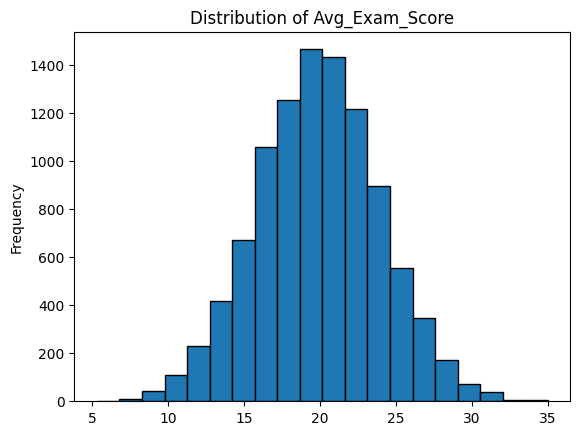

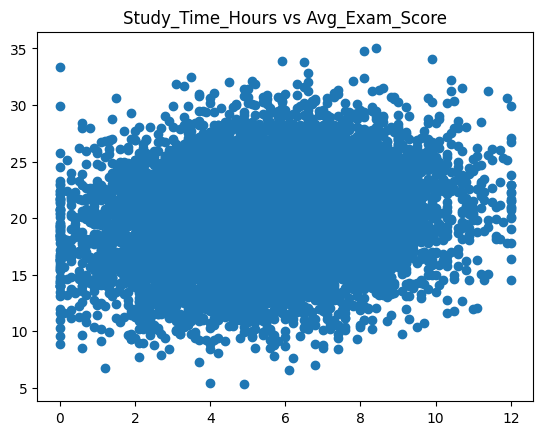

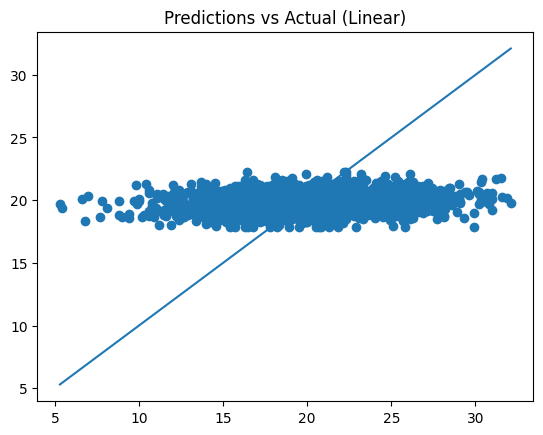

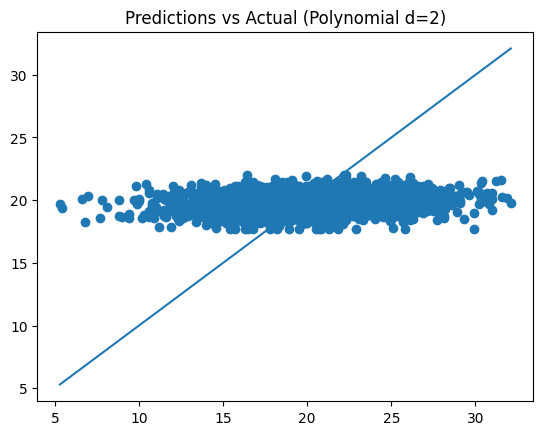

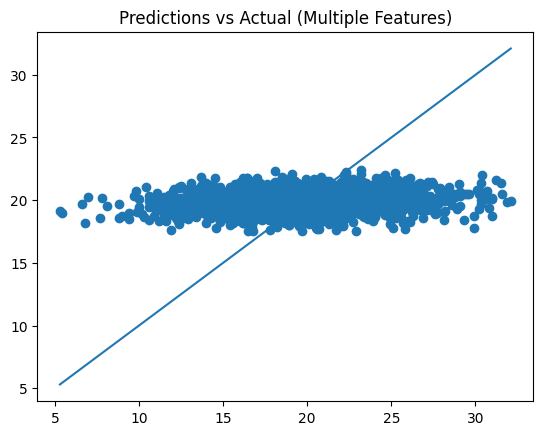


Model Performance Metrics:
                          Model       MAE        MSE      RMSE        R2
0          Linear (Study Hours)  3.155594  15.992479  3.999060  0.023596
1  Polynomial d=2 (Study Hours)  3.156820  15.999755  3.999969  0.023152
2    Linear (Multiple Features)  3.145199  15.883025  3.985351  0.030279

Run Configuration Summary:
  Chosen Study Hours Column Chosen Target Column  Total Rows (after cleaning)  \
0          Study_Time_Hours       Avg_Exam_Score                        10000   

        Numeric Feature Columns Used (Multi-Feature)  
0  Study_Time_Hours, Attendance_Percent, Sleep_Hours  


In [5]:
# Student Score Prediction: Load data, clean, visualize, train/evaluate models

import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------- 1) Load data ----------
data_path = "/content/student_exam_performance_prediction.csv"
assert os.path.exists(data_path), f"File not found at {data_path}"

df_raw = pd.read_csv(data_path)
df = df_raw.copy()

# Standardize column names to snake_case
def to_snake(name: str) -> str:
    s = name.strip().lower()
    s = re.sub(r'[^0-9a-z]+', '_', s)
    s = re.sub(r'^_+|_+$', '', s)
    s = re.sub(r'_+', '_', s)
    return s

original_cols = list(df.columns)
df.columns = [to_snake(c) for c in df.columns]
col_map = dict(zip(df.columns, original_cols))

# ---------- 2) Basic cleaning ----------
for c in df.columns:
    if df[c].dtype == object:
        coerced = pd.to_numeric(df[c], errors="coerce")
        if coerced.notna().sum() > 0:
            non_empty = df[c].astype(str).str.strip().replace("", np.nan).notna().sum()
            if non_empty == 0 or coerced.notna().sum() / max(1, non_empty) >= 0.5:
                df[c] = coerced

df.drop_duplicates(inplace=True)

# ---------- 3) Identify key columns ----------
cols = df.columns.tolist()

study_candidates = [c for c in cols if ("hour" in c and ("study" in c or "stud" in c)) or c in {"study_hours","hours","hours_studied"}]
if "hours_studied" in cols and "hours_studied" not in study_candidates:
    study_candidates.insert(0, "hours_studied")

target_candidates = [c for c in cols if ("exam" in c and ("score" in c or "marks" in c))
                     or ("performance" in c and "index" in c)
                     or c in {"final_score","score","marks","exam_score","performance_index"}]
if "performance_index" in cols and "performance_index" not in target_candidates:
    target_candidates.insert(0, "performance_index")

study_col = study_candidates[0] if study_candidates else None
target_col = target_candidates[0] if target_candidates else None

numeric_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
if study_col is None and numeric_cols:
    study_col = numeric_cols[0]
if target_col is None and numeric_cols:
    target_col = numeric_cols[-1] if numeric_cols[-1] != study_col else (numeric_cols[-2] if len(numeric_cols) > 1 else numeric_cols[0])

assert study_col is not None, "Could not infer the study-hours column. Please check dataset headers."
assert target_col is not None, "Could not infer the target (exam score) column. Please check dataset headers."

work = df.copy()
work = work[pd.notna(work[study_col]) & pd.notna(work[target_col])].copy()

# ---------- 4) Show preview ----------
reverse_name = {k: col_map.get(k, k) for k in work.columns}
preview = work.head(10).copy()
preview.rename(columns=reverse_name, inplace=True)
print("\nPreview of data:")
print(preview)

# ---------- 5) Visualizations ----------
plt.figure()
work[target_col].plot(kind="hist", bins=20, edgecolor="black")
plt.title(f"Distribution of {reverse_name.get(target_col, target_col)}")
plt.show()

plt.figure()
plt.scatter(work[study_col], work[target_col])
plt.title(f"{reverse_name.get(study_col, study_col)} vs {reverse_name.get(target_col, target_col)}")
plt.show()

# ---------- 6) Train/Test split ----------
X_single = work[[study_col]].values
y = work[target_col].values
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_single, y, test_size=0.2, random_state=42)

# ---------- 7) Linear Regression ----------
lr = LinearRegression()
lr.fit(X_train_s, y_train_s)
y_pred_s = lr.predict(X_test_s)

def compute_metrics(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"Model": label, "MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

metrics_rows = []
metrics_rows.append(compute_metrics(y_test_s, y_pred_s, "Linear (Study Hours)"))

plt.figure()
plt.scatter(y_test_s, y_pred_s)
plt.plot([min(y_test_s), max(y_test_s)], [min(y_test_s), max(y_test_s)])
plt.title("Predictions vs Actual (Linear)")
plt.show()

# ---------- 8) Polynomial Regression ----------
poly_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])
poly_pipeline.fit(X_train_s, y_train_s)
y_pred_poly = poly_pipeline.predict(X_test_s)
metrics_rows.append(compute_metrics(y_test_s, y_pred_poly, "Polynomial d=2 (Study Hours)"))

plt.figure()
plt.scatter(y_test_s, y_pred_poly)
plt.plot([min(y_test_s), max(y_test_s)], [min(y_test_s), max(y_test_s)])
plt.title("Predictions vs Actual (Polynomial d=2)")
plt.show()

# ---------- 9) Multiple Linear Regression ----------
feature_cols = [c for c in work.columns if c != target_col and pd.api.types.is_numeric_dtype(work[c])]
X_multi = work[feature_cols].values
y_multi = work[target_col].values

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

lr_multi = LinearRegression()
lr_multi.fit(X_train_m, y_train_m)
y_pred_m = lr_multi.predict(X_test_m)
metrics_rows.append(compute_metrics(y_test_m, y_pred_m, "Linear (Multiple Features)"))

plt.figure()
plt.scatter(y_test_m, y_pred_m)
plt.plot([min(y_test_m), max(y_test_m)], [min(y_test_m), max(y_test_m)])
plt.title("Predictions vs Actual (Multiple Features)")
plt.show()

# ---------- 10) Metrics ----------
metrics_df = pd.DataFrame(metrics_rows)
print("\nModel Performance Metrics:")
print(metrics_df)

# ---------- 11) Summary ----------
chosen_info = {
    "Chosen Study Hours Column": reverse_name.get(study_col, study_col),
    "Chosen Target Column": reverse_name.get(target_col, target_col),
    "Total Rows (after cleaning)": len(work),
    "Numeric Feature Columns Used (Multi-Feature)": ", ".join([reverse_name.get(c, c) for c in feature_cols])
}
print("\nRun Configuration Summary:")
print(pd.DataFrame([chosen_info]))
